In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import clip
import numpy as np
import torch
from PIL import Image
import glob
from Reader_old import ImageReader

/pless_nfs/home/liuxiaotong2017/anaconda3/envs/clipdecoder/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
Dist2.argsort(descending=True)[:,0].cpu()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels,Dist2.argsort(descending=True)[:,0].cpu())[86].argsort()

In [3]:
clip_model, preprocess = clip.load('ViT-L/14', device='cuda')
# data_dict = torch.load('data_dict_iNat_Mammals.pth')
# data_dict_g = torch.load('SDout_data_dict/data_dict_iNat_Mammals.pth')
# data_dict = torch.load('data_dict_iNat_Amphibians.pth')
# data_dict_g = torch.load('SDout_data_dict/data_dict_iNat_Amphibians.pth')
# data_dict = torch.load('data_dict_resisc45.pth')
# data_dict_g = torch.load('SDout_data_dict/data_dict_resisc45_contains.pth')
# data_dict = torch.load('data_dict_DTD.pth')
# data_dict_g = torch.load('SDout_data_dict/data_dict_DTD_obj.pth')
# data_dict = torch.load('data_dict_cifar.pth')
# data_dict_g = torch.load('SDout_data_dict/data_dict_cifar.pth')
data_dict = torch.load('data_dict_CUB.pth')
data_dict_g = torch.load('./SDout_data_dict/data_dict_CUB_natrual.pth')
# # data_dict_t = torch.load('./SDout_data_dict/data_dict_CUB_white.pth')
# data_dict_t = torch.load('./SDout_data_dict/data_dict_CUB_plain.pth')
# data_dict_g = torch.load('data_dict_CUB_sampletest.pth')
# data_dict_g = torch.load('data_dict_CUB_fine_g.pth')
# data_dict_temp = torch.load('data_dict_CUB.pth')
# data_dict_g_temp = torch.load('data_dict_CUB_g.pth')
# data_dict_3 = torch.load('data_dict_CUB_test3.pth')
# data_dict_2 = torch.load('data_dict_CUB_test2.pth')
# data_dict_4 = torch.load('data_dict_CUB_test4.pth')

# data_dict = torch.load('data_dict_dog.pth')
# data_dict_g = torch.load('./SDout_data_dict/data_dict_dog.pth')
# data_dict={}
# # data_dict_g={}
# for i in data_dict_g:
#     data_dict[i] = data_dict_ref[i]
    # data_dict_g[i] = data_dict_g_temp[i]
# data_dict = torch.load('data_dict_flower_sample.pth')
# data_dict_g = torch.load('data_dict_flower_g.pth')
# data_dict = torch.load('data_dict_pet.pth')
# data_dict_g = torch.load('./SDout_data_dict/data_dict_pet_natural.pth')
# data_dict_g = torch.load('data_dict_pet_natural.pth')
# data_dict = torch.load('data_dict_cal_sample.pth')
# data_dict_g = torch.load('data_dict_cal_g.pth')

In [4]:
import torchvision.transforms as transforms
preprocess_show = torch.nn.Sequential(
    transforms.Resize(224),
    transforms.CenterCrop(224),
)
dsets = ImageReader(data_dict, preprocess)
dsets_generate = ImageReader(data_dict_g, preprocess)
# dsets1 = ImageReader(data_dict_1, preprocess)
# dsets2 = ImageReader(data_dict_2, preprocess)
# dsets3 = ImageReader(data_dict_3, preprocess)
# dsets4 = ImageReader(data_dict_4, preprocess)
# dsets_ref = ImageReader(data_dict_ref,preprocess)
# dsets_test= ImageReader(data_dict_t, preprocess)
show_dsets = ImageReader(data_dict,preprocess_show)
show_dsets_g = ImageReader(data_dict_g,preprocess_show)

In [5]:
def eva(dsets, model):
    Fvecs = []# 256-1200/512-400
    Lvecs = []
    dataLoader = torch.utils.data.DataLoader(dsets, batch_size=100)
    torch.set_grad_enabled(False)
    for data in dataLoader:
        inputs_bt, labels_bt = data # <FloatTensor> <LongTensor>
        inputs_bt = inputs_bt.cuda()
        fvec = model.encode_image(inputs_bt).float()
        fvec /= fvec.norm(dim=-1, keepdim=True)
        fvec = fvec.cpu()
        Fvecs.append(fvec)
        Lvecs.append(labels_bt)
    return torch.cat(Fvecs,0),torch.cat(Lvecs,0)

In [6]:
features,labels = eva(dsets,clip_model)
features_g,labels_g = eva(dsets_generate,clip_model)
# features_t,labels_t = eva(dsets_test,clip_model)

In [9]:
def text2vector(classnames,model):
    with torch.no_grad():
        texts = clip.tokenize(classnames).cuda()
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
    return class_embedding

def GetTectVector(sentence,model):
    sentences = []
    for sent in sentence:
        text_features=text2vector(sent,model).t()
        text_features=text_features.cpu().detach().numpy()
        
        text_features=text_features/np.linalg.norm(text_features)
        sentences.append(text_features)
    return sentences

def find_satlist(dataset,o):
    sat_mapping = {}
    satlist = []
    idx = 0
    for i in dataset.class_to_idx:
        if o in i:
            s = i.split('_')[0]
            sat_mapping[dataset.state_to_idx[s]]=idx
            satlist.append(s)
            #y.cpu().apply_(lambda val: d.get(val, val_if_not_shown))
            idx+=1
    return satlist,sat_mapping

def cls_acc(cls,cls_features,model,prompt_sentences,dataset,k=1,satmapping=None):
    text_vectors = torch.tensor(GetTectVector(prompt_sentences,model)).float().cuda()
    if k != 1:
        k = int(k*len(text_vectors))
        if k==0:
            k=1
    D = cls_features@text_vectors.T
    Dist = torch.argsort(D,dim=-1,descending=True)[:,:k]
    res_idx = dataset.class_to_idx[cls]
    if satmapping:
        res_idx = satmapping[res_idx]
    count = torch.count_nonzero(torch.any(Dist==res_idx,dim=1))
    acc = count/len(Dist)
    return acc,count,len(Dist)


def get_sentences(obj,datasets):
    prompt_sentences = []
    prompt_obj = obj_to_prompts[obj]   
        
    for sat in datasets.state_to_idx.keys():
        prompt_sat = sat.lower()
        if prompt_sat == 'leather':
            prompt_sat = 'standard leather'
        if prompt_sat == 'synthetic':
            prompt_sat = 'not-nylon synthetic'
        if '.' in prompt_sat:
            prompt_sat = prompt_sat.replace('.',' ')
        prompt_sentences.append('a photo of '+prompt_obj+' made by '+prompt_sat+ ' material.')
    return prompt_sentences

def get_sentences2(datatset,type="photo"):
    texts = ['a '+type+' of a '+obj.replace('_',' ')+ '.' for obj in datatset.class_to_idx]
    return texts

def get_sentences3(datatset):
    texts = ['a picture of a object with '+obj.replace('_',' ')+ ' textural pattern.' for obj in datatset.class_to_idx]
    return texts

def get_sentences4(datatset):
    texts = ['a satellite image contains  '+obj.replace('_',' ')+ '.' for obj in datatset.class_to_idx]
    return texts

In [10]:
def newtest(obj,all_feature,alllabels,all_text_vector,all_img_vectors,datasets,find_sim=False,textlabel_mapping = None,refer_points=None):
    obj_idx = datasets.class_to_idx[obj]
    text_idx1 = obj_idx
    if textlabel_mapping:
        text_idx1 = textlabel_mapping[obj_idx]
    if not find_sim:
        #text_diff_v = (text_vectors[text_idx1]-text_vectors.mean(dim=0)).detach().cpu().numpy()
        #text_diff_v = (text_vectors[text_idx1]-text_vectors[text_idx2]).detach().cpu().numpy()
        index = torch.ones(all_text_vector.shape[0], dtype=bool)
        index[text_idx1]=False
        # text_diff_v = (all_text_vector[text_idx1]-all_text_vector.mean(dim=0))
        text_diff_v = (all_text_vector[text_idx1]-all_text_vector[index])
        # text_diff_v=text_diff_v.detach().cpu().numpy()
    else:
        text_diff_v = all_text_vector[text_idx1]
    text_diff_v /= text_diff_v.norm(dim=-1,keepdim=True)

    feat1 = all_feature[alllabels==obj_idx].cuda()
    if refer_points is not None:
        feat1 = feat1 - (feat1@refer_points).unsqueeze(1)@refer_points.unsqueeze(0)
    
    if find_sim:
        img_diff_v = feat1
    else:
        index = torch.ones(all_img_vectors.shape[0], dtype=bool)
        index[obj_idx]=False
        img_diff_v = feat1[:,None,:]-all_img_vectors[index][None,:,:]
    #img_diff_v = feat1-all_feature.mean(dim=0)
    # img_diff_v = feat1
    img_diff_v /= img_diff_v.norm(dim=-1,keepdim=True)
    if find_sim:
        sims = img_diff_v@text_diff_v.T
    else:
        sims = (img_diff_v@text_diff_v.T)
        sims = sims.diagonal(dim1=1,dim2=2).min(dim=-1).values
    # sims  = (img_diff_v@text_diff_v.T).min(dim=-1).values
    sims = sims.detach().cpu().numpy()
    sims = sims[~np.isnan(sims)]
    return sims

In [13]:
prompt_sentences = get_sentences2(dsets)
# prompt_sentences = get_sentences2(dsets,type="satellite image")
# prompt_sentences = get_sentences3(dsets)
all_text_vector = GetTectVector(prompt_sentences,clip_model)
all_text_vector = torch.tensor(np.array(all_text_vector)).float().cuda()
refer_points = all_text_vector.mean(dim=0)
all_img_vectors,all_img_vectors_g,all_img_vectors_t = [],[],[]
all_img_vectors_tang,all_img_vectors_g_tang,all_img_vectors_t_tang = [],[],[]
features,features_g = features.cuda(),features_g.cuda()
for i in range(0,len(prompt_sentences)):
    candi_features = features[labels==i].mean(dim=0)
    all_img_vectors.append(candi_features)
    candi_features_g = features_g[labels_g==i].mean(dim=0)
    all_img_vectors_g.append(candi_features_g)
all_img_vectors = torch.stack(all_img_vectors,dim=0).float().cuda()
all_img_vectors_g = torch.stack(all_img_vectors_g,dim=0).float().cuda()

means_dict = {}
stds_dict = {}
sim_dict = {}

sim_dict_g = {}
means_g_dict = {}
stds_g_dict = {}
acc_dict = {}


for obj in dsets.class_to_idx:

    print(obj)
    idx_obj = (labels == dsets.class_to_idx[obj])
    obj_features = features[idx_obj]
    sims = newtest(obj,features,labels,all_text_vector,all_img_vectors,dsets,find_sim=False,textlabel_mapping = None)
    sim_dict[obj]=sims
    means_dict[obj]=sims.mean()
    stds_dict[obj]=sims.std()

    sims_g = newtest(obj,features_g,labels_g,all_text_vector,all_img_vectors_g,dsets,find_sim=False,textlabel_mapping = None)
    sim_dict_g[obj]=sims_g
    means_g_dict[obj]=sims_g.mean()
    stds_g_dict[obj]=sims_g.std()

    acc = cls_acc(obj,obj_features,clip_model,prompt_sentences,dsets,k=1)
    acc_dict[obj]=acc

airplane


/tmp/ipykernel_28171/3645801927.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/torch/csrc/utils/tensor_new.cpp:201.)
  text_vectors = torch.tensor(GetTectVector(prompt_sentences,model)).float().cuda()


airport
baseball_diamond
basketball_court
beach
bridge
chaparral
church
circular_farmland
cloud
commercial_area
dense_residential
desert
forest
freeway
golf_course
ground_track_field
harbor
industrial_area
intersection
island
lake
meadow
medium_residential
mobile_home_park
mountain
overpass
palace
parking_lot
railway
railway_station
rectangular_farmland
river
roundabout
runway
sea_ice
ship
snowberg
sparse_residential
stadium
storage_tank
tennis_court
terrace
thermal_power_station
wetland


In [ ]:
hlist = []
hlist2 = []
# for s in ['Bombay','Ragdoll','Persian','basset_hound']:
for s in ["Orange_crowned_Warbler","Canada_Warbler","Myrtle_Warbler","Lazuli_Bunting","Painted_Bunting"]:
# for s,v in sorted(means_g_dict.items(),key = lambda x:x[1]):
    idx = np.random.choice(torch.where(labels == dsets.class_to_idx[s])[0].numpy())
    idx2 = np.random.choice(torch.where(labels_g == dsets_generate.class_to_idx[s])[0].numpy())
    images = np.array(show_dsets[idx][0])
    images2 = np.array(show_dsets_g[idx2][0])
    hlist.append(images)
    hlist2.append(images2)
    print(s,means_g_dict[s],acc_dict[s][0])
res = np.hstack(hlist)
res2 = np.hstack(hlist2)
res = np.vstack([res,res2])

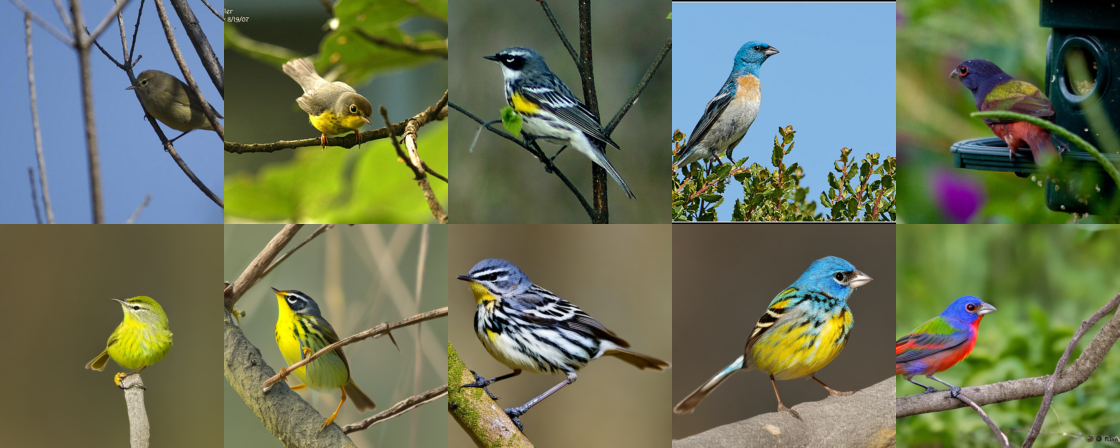

In [101]:
Image.fromarray(res)

In [14]:
import pandas as pd
all_x_labels = []
all_avg = []
all_acc = []
all_avg_g = []
all_avg_t = []
acc_vis={}
avg_vis = {}
avg_vis_g = {}

all_avg1= []
all_avg2 = []
all_avg3 = []
all_avg4 = []

x_vis = {}
count = 0
error_list = []
df = pd.DataFrame(columns=['tsne_x','tsne_y','class_id','label_id','classname','image_path'])
for j in sim_dict:
    avg_val = np.array(sim_dict[j]).mean()
    avg_val_g = np.array(sim_dict_g[j]).mean()
    acc_val = acc_dict[j][0].item()

    all_acc.append(acc_val)
    all_avg.append(avg_val)
    all_avg_g.append(avg_val_g)

In [ ]:
mytest = []
for i in acc_dict:
    if "Warbler" in i:
    # if acc_dict[i][0]>0.5 and means_g_dict[i]>0.05:
        mytest.append((i,acc_dict[i][0],means_g_dict[i]))
        print(i,acc_dict[i][0],means_g_dict[i])

In [ ]:
sorted(mytest,key= lambda x:x[2])

In [26]:
all_avg = np.array(all_avg)
all_acc = np.array(all_acc)
all_avg_g = np.array(all_avg_g)
mask = ~np.isnan(all_avg_g)
all_avg=all_avg[mask]
all_acc=all_acc[mask]
all_avg_g=all_avg_g[mask]

/pless_nfs/home/liuxiaotong2017/anaconda3/envs/clipdecoder/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/pless_nfs/home/liuxiaotong2017/anaconda3/envs/clipdecoder/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/pless_nfs/home/liuxiaotong2017/anaconda3/envs/clipdecoder/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/pless_nfs/home/liuxiaotong2017/anaconda3/envs/clipdecoder/lib/python3.10/site-packages/seaborn/_

pearsonr 0.7769021598986443 0.39636139334606335
spearmanr 0.7857865754181957 0.3641830783710205


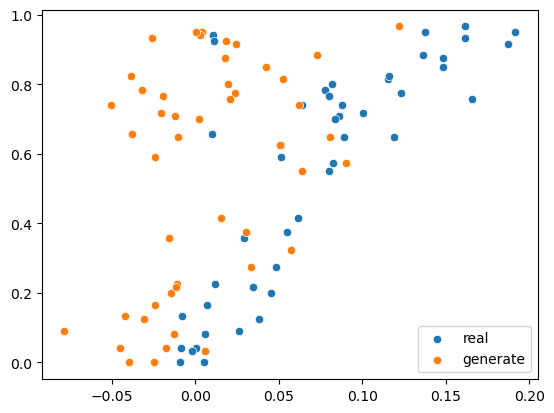

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sca=sns.scatterplot(x=all_avg,y=all_acc)
sca = sns.scatterplot(x=all_avg_g,y=all_acc)
# sns.scatterplot(x=all_avg1,y=all_acc)
# sns.scatterplot(x=all_avg2,y=all_acc)
# sns.scatterplot(x=all_avg3,y=all_acc)
# sns.scatterplot(x=all_avg4,y=all_acc)
# sns.scatterplot(x=all_avg_t,y=all_acc)
# sca.legend(['precise','imprecise'],loc='lower right')
sca.legend(['real','generate'],loc='lower right')
# sca.set(xlim=(-0.15, 0.4))
# sca.set(xlim=(-0.22, 0.27))
from scipy.stats import kstest
from scipy import stats
r,p = stats.pearsonr(np.array(all_avg_g), all_acc,alternative='greater')
# r4,_ = stats.pearsonr(np.array(all_avg4), all_acc,alternative='greater')
# r3,_ = stats.pearsonr(np.array(all_avg3), all_acc,alternative='greater')
# r2,_ = stats.pearsonr(np.array(all_avg2), all_acc,alternative='greater')
# r4,p = stats.spearmanr(np.array(all_avg_t), all_acc,alternative='greater')
r1,p = stats.pearsonr(np.array(all_avg), all_acc,alternative='greater')
print('pearsonr',r1,r)#,r4)
r,p = stats.spearmanr(np.array(all_avg_g), all_acc,alternative='greater')
# r4,_ = stats.spearmanr(np.array(all_avg4), all_acc,alternative='greater')
# r3,_ = stats.spearmanr(np.array(all_avg3), all_acc,alternative='greater')
# r2,_ = stats.spearmanr(np.array(all_avg2), all_acc,alternative='greater')
# r4,p = stats.spearmanr(np.array(all_avg_t), all_acc,alternative='greater')
r1,p = stats.spearmanr(np.array(all_avg), all_acc,alternative='greater')
print('spearmanr',r1,r)#,r4)

pearsonr 0.6236485687869631 0.46329767950597045
spearmanr 0.581916481500752 0.4076710480819538


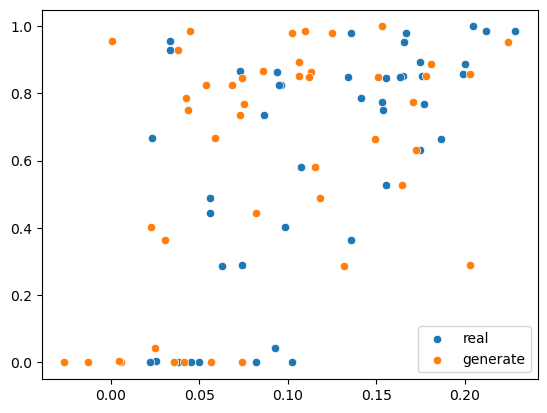

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sca=sns.scatterplot(x=all_avg,y=all_acc)
sca = sns.scatterplot(x=all_avg_g,y=all_acc)
# sns.scatterplot(x=all_avg1,y=all_acc)
# sns.scatterplot(x=all_avg2,y=all_acc)
# sns.scatterplot(x=all_avg3,y=all_acc)
# sns.scatterplot(x=all_avg4,y=all_acc)
# sns.scatterplot(x=all_avg_t,y=all_acc)
# sca.legend(['precise','imprecise'],loc='lower right')
sca.legend(['real','generate'],loc='lower right')
# sca.set(xlim=(-0.15, 0.4))
# sca.set(xlim=(-0.22, 0.27))
from scipy.stats import kstest
from scipy import stats
r,p = stats.pearsonr(np.array(all_avg_g), all_acc,alternative='greater')
# r4,_ = stats.pearsonr(np.array(all_avg4), all_acc,alternative='greater')
# r3,_ = stats.pearsonr(np.array(all_avg3), all_acc,alternative='greater')
# r2,_ = stats.pearsonr(np.array(all_avg2), all_acc,alternative='greater')
# r4,p = stats.spearmanr(np.array(all_avg_t), all_acc,alternative='greater')
r1,p = stats.pearsonr(np.array(all_avg), all_acc,alternative='greater')
print('pearsonr',r1,r)#,r4)
r,p = stats.spearmanr(np.array(all_avg_g), all_acc,alternative='greater')
# r4,_ = stats.spearmanr(np.array(all_avg4), all_acc,alternative='greater')
# r3,_ = stats.spearmanr(np.array(all_avg3), all_acc,alternative='greater')
# r2,_ = stats.spearmanr(np.array(all_avg2), all_acc,alternative='greater')
# r4,p = stats.spearmanr(np.array(all_avg_t), all_acc,alternative='greater')
r1,p = stats.spearmanr(np.array(all_avg), all_acc,alternative='greater')
print('spearmanr',r1,r)#,r4)

In [16]:
for k,v in means_dict.items():
    if v<0.1 and acc_dict[k][0]>0.6:
        print(k,v,acc_dict[k],means_dict[k])

dense_residential 0.033317447 (tensor(0.9557, device='cuda:0'), tensor(669, device='cuda:0'), 700) 0.033317447
freeway 0.033428703 (tensor(0.9300, device='cuda:0'), tensor(651, device='cuda:0'), 700) 0.033428703
ground_track_field 0.08649346 (tensor(0.7357, device='cuda:0'), tensor(515, device='cuda:0'), 700) 0.08649346
mobile_home_park 0.096053205 (tensor(0.8257, device='cuda:0'), tensor(578, device='cuda:0'), 700) 0.096053205
mountain 0.094924994 (tensor(0.8257, device='cuda:0'), tensor(578, device='cuda:0'), 700) 0.094924994
railway_station 0.02333095 (tensor(0.6671, device='cuda:0'), tensor(467, device='cuda:0'), 700) 0.02333095
rectangular_farmland 0.09407733 (tensor(0.8643, device='cuda:0'), tensor(605, device='cuda:0'), 700) 0.09407733
runway 0.07279638 (tensor(0.8657, device='cuda:0'), tensor(606, device='cuda:0'), 700) 0.07279638
